# Convolutional Neural Networks for DNA sequence data to predict cell type specific promoters


## Load libraries

In [ ]:
import tensorflow as tf

import keras
import keras.layers as kl
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers import BatchNormalization, InputLayer, Input
from keras import models
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History, ModelCheckpoint
import sklearn 
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('Neural_Network_DNA_Demo/')
from helper import IOHelper, SequenceHelper # from https://github.com/const-ae/Neural_Network_DNA_Demo

import random
random.seed(1234)
import anndata


## Load promoter status files

In [2]:
Y_anndata = anndata.read_h5ad("/home/haoy/share/CutTag/DeepLearning/chrAll_Allthree_prob.h5ad")

In [3]:
Y_anndata = Y_anndata[["promoter" in w for w in  Y_anndata.obs.index] ,:]

In [4]:
Y_anndata.obs


,obs1
B_promoter,a
CD4 T_promoter,a
CD8 T_promoter,a
Mono_promoter,a


In [6]:
peaks_mean = Y_anndata.X.sum(axis = 0).flatten()
peaks_mean = np.asarray(peaks_mean).flatten()

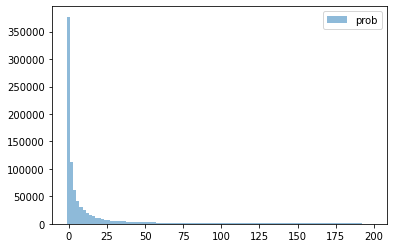

In [8]:
bins = np.linspace(-1, np.max(peaks_mean), 100)
plt.hist(peaks_mean, bins, alpha=0.5, label='prob')

plt.legend(loc='upper right')
plt.show()

In [9]:
## select positive and negative

pos_ind = np.where(peaks_mean > 45 )[0]
neg_ind = np.where(peaks_mean <= 45)[0]
print(len(neg_ind)/len(pos_ind))

6.534304487767456


In [253]:
len(neg_ind[np.where(np.random.binomial(1, 0.2, len(neg_ind)) * neg_ind != 0)]) / len(pos_ind)
np.random.seed(0)
neg_ind_filter =  neg_ind[np.where(np.random.binomial(1, 0.2, len(neg_ind)) * neg_ind != 0)]
all_ind = [*pos_ind, *neg_ind_filter]

In [12]:

task_name = Y_anndata.obs.index.to_numpy().tolist()
task_name = [w.replace("_", "") for w in task_name]
task_name = [w.replace(" ", "") for w in task_name]
task_name

['Bpromoter', 'CD4Tpromoter', 'CD8Tpromoter', 'Monopromoter']

## Load the sequence data

There are two example files available `data/ctcf.fa.gz` and `data/pu1.fa.gz`

In [13]:
input_fasta_data = IOHelper.get_fastas_from_file("/home/haoy/share/CutTag/DeepLearning/chrAll_Allthree_Sequence.fa", uppercase=True)
sequence_length = len(input_fasta_data.sequence[0])
seq_matrix = SequenceHelper.do_one_hot_encoding(input_fasta_data.sequence, sequence_length,
                                                SequenceHelper.parse_alpha_to_seq)

In [14]:
CG_filter = SequenceHelper.do_one_hot_encoding(np.array(["C","G"]), 1,
                                                SequenceHelper.parse_alpha_to_seq)
CG_filter = CG_filter.reshape(2,4)

In [15]:
def GC_content(seq_mat):
    seq_CG = (seq_mat @ CG_filter.T) 
    indexer = np.arange(4)[None, :] + 2*np.arange(seq_CG.shape[0]-1)[:, None]
    seq_CG = seq_CG.flatten()
    gc_num = np.sum((seq_CG[indexer] == [1,0,0,1]).all(axis=1))
    return gc_num


In [254]:
GC_all = [GC_content(seq_matrix[i]) for i in range(seq_matrix.shape[0]) ]
GC_all = np.array( GC_all)

In [255]:
import matplotlib 
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

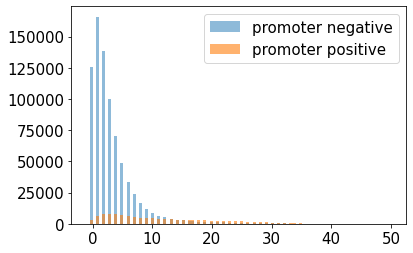

In [256]:

bins = np.linspace(-1, 50, 100)
plt.hist(GC_all[neg_ind ], bins, alpha=0.5, label='promoter negative')
plt.hist(GC_all[pos_ind ], bins, alpha=0.6, label='promoter positive')

plt.legend(loc='upper right')
plt.show()

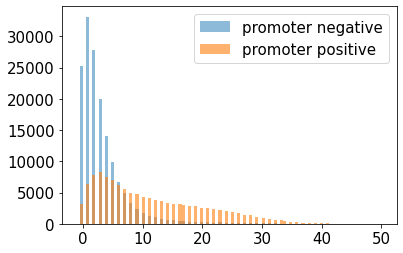

In [257]:
bins = np.linspace(-1, 50, 100)
plt.hist(GC_all[neg_ind_filter ], bins, alpha=0.5, label='promoter negative')
plt.hist(GC_all[pos_ind ], bins, alpha=0.6, label='promoter positive')

plt.legend(loc='upper right')
plt.show()

In [258]:

GC_all = GC_all.clip(None, 50)
hist, bin_edges = np.histogram(GC_all[pos_ind ], bins=100000, density=True)
hist_2, bin_edges_2 = np.histogram(GC_all[neg_ind ], bins=100000, density=True)


hist_ratio = hist/hist_2

/home/haoy/miniconda3/envs/DeepSTARR-GPU/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/haoy/miniconda3/envs/DeepSTARR-GPU/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [260]:
hist_index = np.where( np.isfinite(hist_ratio)  )

bin_edges_select =  bin_edges[1:][hist_index]
hist_select =  hist_ratio[hist_index]
print(hist_select)

[  0.16392583   0.25017155   0.37022851   0.53577503   0.69945746
   0.9372719    1.21725825   1.53483036   1.95279869   2.58264745
   3.17846814   4.14698396   4.84050728   6.02637882   6.87725401
   7.90916946   8.89844619  10.04844084  10.78885448  12.30112833
  11.6764983   13.03298582  14.4382185   14.42454172  15.20585511
  15.54571937  15.46236408  15.35822927  16.9123175   17.83352935
  19.6225951   18.2442957   16.7779322   16.80249725  18.63159793
  16.61010225  19.85749676  18.44360138  15.70525815  19.60291346
  21.15870025  24.62930153  26.13721795  44.10655529 111.08317629
  28.31531945  13.06860898  16.33576122   9.80145673   6.53430449]


In [262]:
bins_nn = bin_edges_select
bins_nn = bins_nn.reshape( len(bin_edges_select), 1)

### Equalize positive and negative peaks

In [263]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2 )
neigh.fit( bins_nn  )

NearestNeighbors(n_neighbors=2)

In [264]:
neg_nn = neigh.kneighbors(GC_all[neg_ind ].reshape(len(neg_ind) ,1), 1, return_distance=False)
neg_prob = hist_select[neg_nn.reshape(-1)]  
neg_prob = neg_prob/ np.sum(neg_prob)

In [265]:
sample_prob = neg_prob
np.random.seed(0)
neg_ind_filter = np.random.choice(neg_ind, size = round(len(pos_ind) *1.2) ,replace=True,  p =  sample_prob)

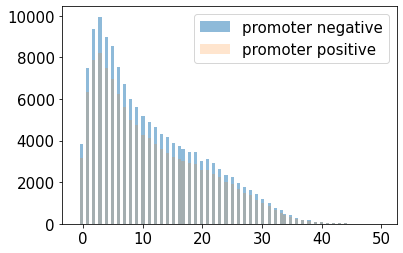

In [266]:

bins = np.linspace(-1, 50, 100)
plt.hist(GC_all[neg_ind_filter ], bins, alpha=0.5, label='promoter negative')
plt.hist(GC_all[pos_ind ], bins, alpha=0.2, label='promoter positive')

plt.legend(loc='upper right')
plt.show()

In [267]:
all_ind = [*pos_ind, *neg_ind_filter]

In [268]:
# check NA
array_sum = np.sum(seq_matrix)
array_has_nan = np.isnan(array_sum)
array_has_nan



False

## Create a test and a training subset

To have a reasonable estimate of the training, the data is split into a training (80%) and a test (20%) set.def reshape_Y(array):
    Y_list = []
    for i in range(array.shape[1]):
        y_i = pd.Series(array[:,i])
        y_i.name = task_name[i]
        Y_list.append(y_i)
    return( Y_list)

In [269]:
def reshape_Y(array):
    Y_list = []
    for i in range(array.shape[1]):
        y_i = pd.Series(array[:,i])
        y_i.name = task_name[i]
        Y_list.append(y_i)
    return( Y_list)

In [270]:
np.random.seed(0)
# Create a random index
shuffling_index = np.arange(len(all_ind) )
np.random.shuffle(shuffling_index)

# Full data set Y ~ X where Y is a vector of 0s and 1s and X is the 
# corresponding sequence data
X = seq_matrix[all_ind, :, :]
X = X[shuffling_index, :, :]
X = np.nan_to_num(X)
Y =  Y_anndata.X.A.T / 50
Y = Y[all_ind,:]
#Y = np.log(Y_anndata.X.A.T * 1000 + 1)
#Y = preprocessing.scale(Y, axis=0, with_mean=True, with_std=True)                      
Y = Y[shuffling_index,:]

# Splitting the data into a training and a test set
X_train = X[0:int(X.shape[0]*0.8), :, :]
Y_train = Y[0:int(X.shape[0]*0.8)]

X_test = X[int(X.shape[0]*0.8):X.shape[0], :, :]
Y_test = Y[int(X.shape[0]*0.8):X.shape[0]]

Y_train = reshape_Y(Y_train)
Y_test = reshape_Y(Y_test)
print(X_train.shape)
print(Y_train[0].shape)

(211069, 200, 4)
(211069,)


In [272]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print(X_train_reshaped.shape)
print(X_test_reshaped.shape)

(211069, 200, 4)
(52768, 200, 4)


In [273]:

loss_poisson = tf.keras.losses.Poisson()

In [274]:
from scipy.stats import spearmanr
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )
 
     


params = {'batch_size': 128,
          'epochs': 50,
          'early_stop': 10,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 4,
          'lr': 0.002,
          'num_filters': 256,
          'num_filters2': 60,
          'num_filters3': 60,
          'num_filters4': 120,
          'n_conv_layer': 4,
          'n_add_layer': 4,
          'dropout_prob': 0.2,
          'dense_neurons1': 256,
          'dense_neurons2': 128,
          'dense_neurons3': 50,
        'dense_neurons4': 256,

          'pad':'same'}

def CutTagDL(params=params):
    
    lr = params['lr']
    dropout_prob = params['dropout_prob']
    n_conv_layer = params['n_conv_layer']
    n_add_layer = params['n_add_layer']
    
    input = kl.Input(shape=(200, 4))
    x = kl.Conv1D(params['num_filters'], kernel_size=params['kernel_size1'],
                  padding=params['pad'],
                  name='Conv1D_1st')(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)

    for i in range(1, n_conv_layer):
        x = kl.Conv1D(params['num_filters'+str(i+1)],
                      kernel_size=params['kernel_size'+str(i+1)],
                      padding=params['pad'],
                      name=str('Conv1D_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    
    # dense layers
    for i in range(0, n_add_layer):
        x = kl.Dense(params['dense_neurons'+str(i+1)],
                     name=str('Dense_'+str(i+1)))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_prob)(x)
    bottleneck = x
    
    # heads per task (developmental and housekeeping enhancer activities)
    tasks = task_name
    outputs = []
    for task in tasks:
        outputs.append(kl.Dense(1, activation='sigmoid', name=str('Dense_' + task))(bottleneck))

    model = keras.models.Model([input], outputs)
    model.compile(keras.optimizers.Adam(lr=lr),
                  loss= np.repeat(loss_poisson,len(tasks)).tolist() , # loss
                  loss_weights=np.repeat(1,len(tasks)).tolist() ,  # loss weigths to balance
                  metrics=[Spearman]) # additional track metric

    return model, params
CutTagDL()[0].summary()
CutTagDL()[1]






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 4)       0                                            
__________________________________________________________________________________________________
Conv1D_1st (Conv1D)             (None, 200, 256)     7424        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 256)     1024        Conv1D_1st[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 200, 256)     0           batch_normalization_1[

2021-12-06 18:04:47.568218: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-12-06 18:04:47.595608: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2345700000 Hz
2021-12-06 18:04:47.600347: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5572798639a0 executing computations on platform Host. Devices:
2021-12-06 18:04:47.600362: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>


{'batch_size': 128,
 'epochs': 50,
 'early_stop': 10,
 'kernel_size1': 7,
 'kernel_size2': 3,
 'kernel_size3': 5,
 'kernel_size4': 3,
 'lr': 0.002,
 'num_filters': 256,
 'num_filters2': 60,
 'num_filters3': 60,
 'num_filters4': 120,
 'n_conv_layer': 4,
 'n_add_layer': 4,
 'dropout_prob': 0.2,
 'dense_neurons1': 256,
 'dense_neurons2': 128,
 'dense_neurons3': 50,
 'dense_neurons4': 256,
 'pad': 'same'}

In [275]:
def train(selected_model, X_train, Y_train, X_valid, Y_valid, params):

    my_history=selected_model.fit(X_train_reshaped, Y_train,
                                  validation_data=(X_test_reshaped, Y_test),
                                  batch_size=params['batch_size'], epochs=params['epochs'],
                                  callbacks=[EarlyStopping(patience=params['early_stop'], monitor="val_loss", restore_best_weights=True),
                                             History()])
    
    return selected_model, my_history
main_model, main_params = CutTagDL()

In [276]:

main_model, my_history = train(main_model, X_train_reshaped, Y_train, X_test_reshaped, Y_test, main_params)

pred_train = main_model.predict(X_train, batch_size=main_params['batch_size'])
pred_test = main_model.predict(X_test, batch_size=main_params['batch_size'])



Train on 211069 samples, validate on 52768 samples
Epoch 1/50


2021-12-06 18:05:02.656557: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


211069/211069 [==============================] - 109s 515us/step - loss: 2.4569 - Dense_Bpromoter_loss: 0.6591 - Dense_CD4Tpromoter_loss: 0.6211 - Dense_CD8Tpromoter_loss: 0.6343 - Dense_Monopromoter_loss: 0.5424 - Dense_Bpromoter_Spearman: 0.3244 - Dense_CD4Tpromoter_Spearman: 0.3091 - Dense_CD8Tpromoter_Spearman: 0.3021 - Dense_Monopromoter_Spearman: 0.2901 - val_loss: 2.5121 - val_Dense_Bpromoter_loss: 0.6720 - val_Dense_CD4Tpromoter_loss: 0.6349 - val_Dense_CD8Tpromoter_loss: 0.6462 - val_Dense_Monopromoter_loss: 0.5590 - val_Dense_Bpromoter_Spearman: 0.3679 - val_Dense_CD4Tpromoter_Spearman: 0.3500 - val_Dense_CD8Tpromoter_Spearman: 0.3472 - val_Dense_Monopromoter_Spearman: 0.3307
Epoch 2/50
211069/211069 [==============================] - 100s 476us/step - loss: 2.4213 - Dense_Bpromoter_loss: 0.6497 - Dense_CD4Tpromoter_loss: 0.6125 - Dense_CD8Tpromoter_loss: 0.6247 - Dense_Monopromoter_loss: 0.5344 - Dense_Bpromoter_Spearman: 0.3836 - Dense_CD4Tpromoter_Spearman: 0.3686 - Dense_

In [277]:
model_name="Promoter_poisson_GC"
main_model.save(model_name)

In [ ]:
# main_model = keras.models.load_model('/home/haoy/Promoter_poisson', compile=False)

In [278]:
### Additional metrics
from scipy.stats import spearmanr
def Spearman(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32), 
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )
 

In [279]:
params = {'batch_size': 128,
          'epochs': 50,
          'early_stop': 10,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'lr': 0.002,
          'num_filters': 256,
          'num_filters2': 60,
          'num_filters3': 60,
          'num_filters4': 120,
          'n_conv_layer': 4,
          'n_add_layer': 4,
          'dropout_prob': 0.2,
          'dense_neurons1': 256,
          'dense_neurons2': 128,
          'dense_neurons3': 50,
        'dense_neurons4': 256,

          'pad':'same'}

In [280]:
pred_all = main_model.predict(seq_matrix, batch_size=main_params['batch_size'])
Y_all = reshape_Y(Y_anndata.X.A.T )

# 

In [ ]:
from scipy import stats
from sklearn.metrics import mean_squared_error

# create functions
def summary_statistics(X, Y, set, task_id, pred):
    

    print(set + ' MSE ' + task_name[task_id] + ' = ' + str("{0:0.3f}".format(mean_squared_error(Y, pred[task_id].squeeze()))))
    print(set + ' PCC ' + task_name[task_id] + ' = ' + str("{0:0.3f}".format(stats.pearsonr(Y, pred[task_id].squeeze())[0])))
    print(set + ' SCC ' + task_name[task_id] + ' = ' + str("{0:0.3f}".format(stats.spearmanr(Y, pred[task_id].squeeze())[0])))


# run for each set and enhancer type
summary_statistics(X_train, Y_train[0], "train", 0, pred_train)
summary_statistics(X_train, Y_train[1], "train", 1, pred_train)
summary_statistics(X_train, Y_train[0], "train", 2, pred_train)
summary_statistics(X_train, Y_train[1], "train", 3, pred_train)

 
summary_statistics(X_test, Y_test[0], "test", 0, pred_test)
summary_statistics(X_test, Y_test[1], "test", 1, pred_test)


In [ ]:
task_name

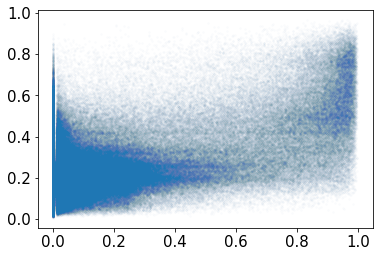

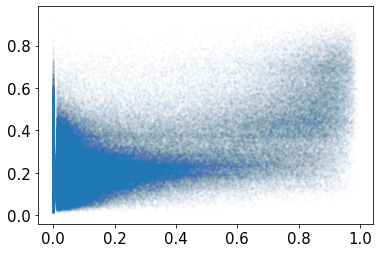

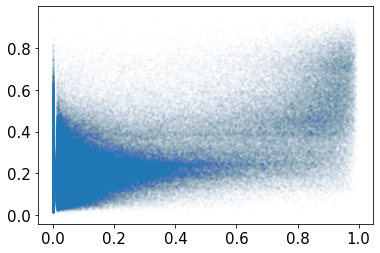

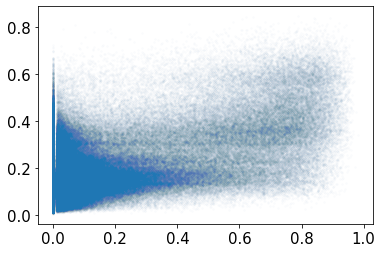

In [282]:
plt.scatter( Y_all[0]/50 ,pred_all[0], alpha=0.01, s=3)
plt.show()
plt.scatter( Y_all[1]/50 ,pred_all[1], alpha=0.01, s=3)
plt.show()
plt.scatter( Y_all[2]/50 ,pred_all[2], alpha=0.01, s=3)
plt.show()
plt.scatter( Y_all[3]/50 ,pred_all[3], alpha=0.01, s=3)
plt.show()

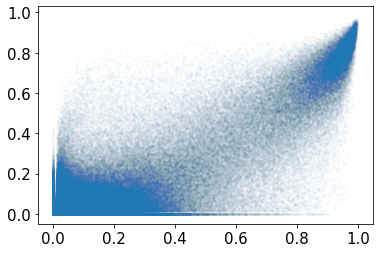

In [285]:
 plt.scatter(Y_all[0]/50,Y_all[3]/50, alpha=0.01, s=3)


In [ ]:
Y_raw  = Y_anndata.X.A.T/50

In [ ]:
print(Y_raw[747505,])

In [104]:
np.where(input_fasta_data.location == "chr9_37034200_37034400_+_positive_peaks")

(array([416441]),)

In [105]:
np.where(input_fasta_data.location == "chr9_37021000_37021200_+_positive_peaks")
 

(array([416375]),)

## Calculate base pair importance score

In [286]:
def calculate_importance_score(seq_mat, pred, return_mean = True):
    tmp = np.repeat(seq_mat, 200, axis=0)
    a = np.ones((200, 200), int)
    np.fill_diagonal(a, 0)
    b = np.repeat(a.reshape((1,200,200)), seq_mat.shape[0], axis=0)
    c = np.concatenate(b, axis=0)
    d = np.multiply(tmp, np.repeat(c.reshape((tmp.shape[0], 200, 1)), 4, axis=2))
    d_pred = main_model.predict(d, batch_size=main_params['batch_size']) 
    scores = [np.reshape((np.repeat(pred[i].flatten(), 200) - d_pred[i].flatten()), (seq_mat.shape[0],200))  for i in range(0,len(task_name))]
    if return_mean:
        scores_mean = [ ( scores[i] + np.abs(  scores[i])).mean(axis = 1)  for i in range(0,len(task_name))]
        return (scores_mean)
    else: 
        return(scores)

In [ ]:
score_all = []
batch_i = 5000
for i in range(0, seq_matrix.shape[0], batch_i):
    print(i)
    plot_index = range(i,i+batch_i) 
    seq_matrix_for_plotting = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2]))[plot_index, :]
    plotting_pred_all = [ pred_all[i][plot_index]  for i in range(0,len(task_name))]
    score_all.append(calculate_importance_score(seq_matrix_for_plotting, plotting_pred_all))



In [89]:
score_all_0 = np.array([  score_all[i][0]  for i in range( len(score_all ))]).reshape(-1)
score_all_1 = np.array([  score_all[i][1]  for i in range( len(score_all ) ) ]).reshape(-1)
score_all_2 = np.array([  score_all[i][2]  for i in range( len(score_all )  ) ]).reshape(-1)
score_all_3 = np.array([  score_all[i][3]  for i in range( len(score_all ) ) ]).reshape(-1)


In [293]:
select_idx =  416441

In [294]:

select_idx = range(select_idx, select_idx+1)
seq_matrix_i = seq_matrix.reshape((seq_matrix.shape[0], seq_matrix.shape[1], seq_matrix.shape[2]))[select_idx, :]
pred_i = [ pred_all[i][select_idx]  for i in range(0,len(task_name))]
score_i = calculate_importance_score(seq_matrix_i, pred_i, return_mean=False) 
 

In [ ]:
input_fasta_data.sequence[select_idx[0]]

'TGAGCTGAAACTAAACGTTTTAGGTGGAAAAAAAGCGTCCGAAGGCACCGTGAAATGATTAAGGAACTAAAGAGCTTCTCGCCATGTGAGATCATGTCCTGTTCTCGCCAACATCACAAGATGTCCCCAGACACGCCGCGCCCCCAGCGCGCCGCCCCACACTGCCGGCCCGGAGCGAGGAAAGGGTAGGCGCTGCGCGG'

In [297]:
score_limit = [np.min( (score_i)), np.max( (score_i)) ]

#### Make the Actual Plot

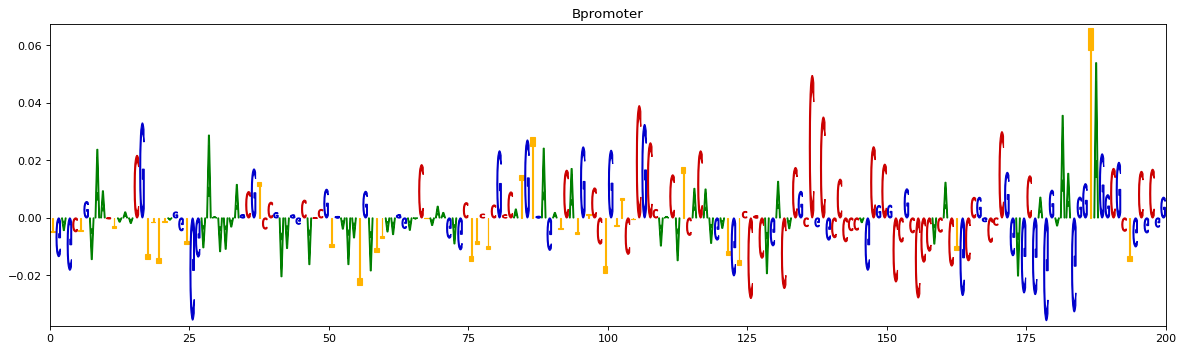

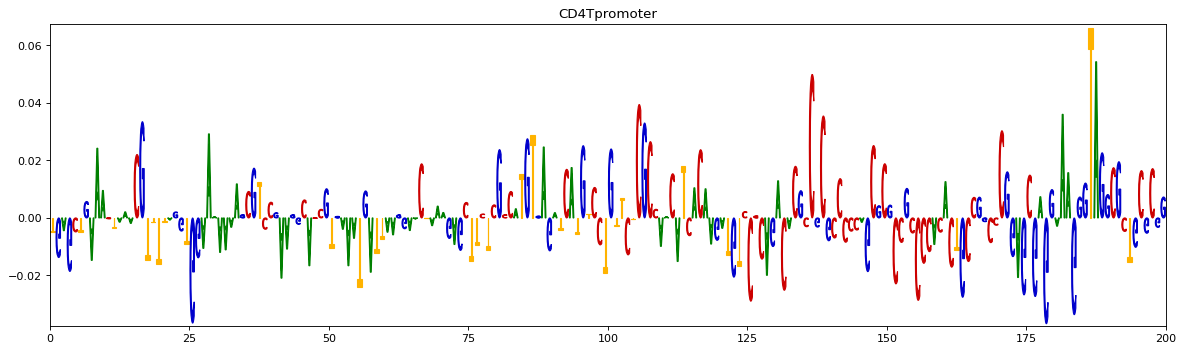

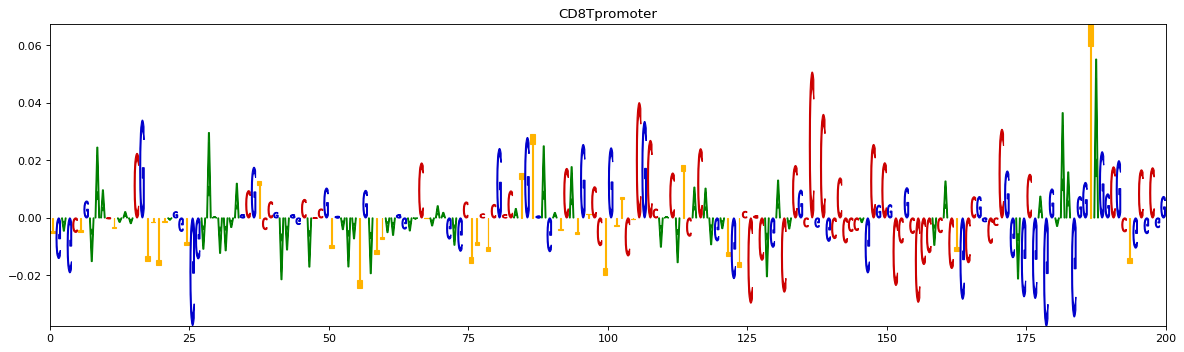

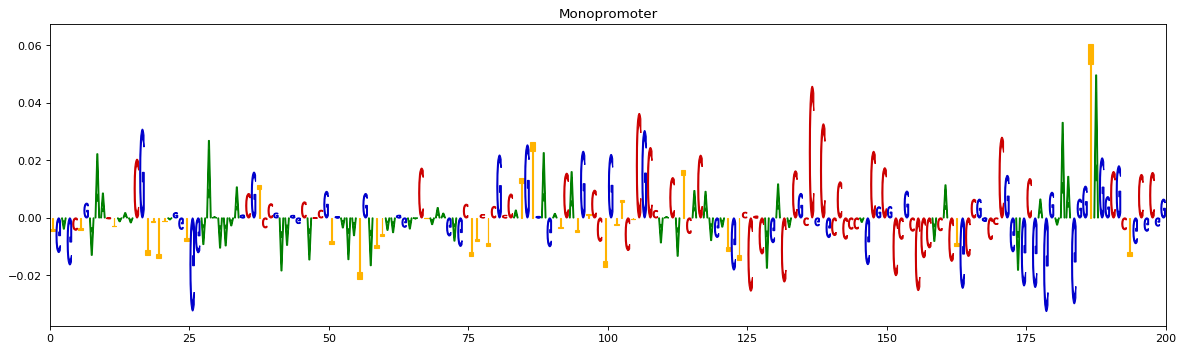

In [298]:
%matplotlib inline

import motif_plotter # from https://github.com/bernardo-de-almeida/DeepSTARR/tree/main/DeepSTARR/Neural_Network_DNA_Demo/motif_plotter
import matplotlib.pyplot as plt

for idx in range(0, len(task_name)):
    fig=plt.figure(figsize=(18, 5), dpi= 80)
    ax=fig.add_subplot(111)
    motif_plotter.make_single_sequence_spectrum(ax, 
                                                seq_matrix_i[0].reshape((200, 4)),
                                                 (score_i[idx]).reshape(200,1),
                                                one_hot_decoding=["A", "C", "G", "T"] )
    ax.set_ylim(score_limit[0],score_limit[1])
    ax.set_title(task_name[idx])
    plt.show()
